In [89]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import torch


In [90]:
path="data/raw/HIV.csv"
data=pd.read_csv(path)

In [91]:
type(data),data.shape,data.ndim

(pandas.core.frame.DataFrame, (41127, 3), 2)

In [92]:
type(data['smiles'])

pandas.core.series.Series

In [93]:
data.isnull().value_counts()

smiles  activity  HIV_active
False   False     False         41127
Name: count, dtype: int64

In [94]:
data.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [95]:
data.shape,data["HIV_active"].value_counts()

((41127, 3),
 HIV_active
 0    39684
 1     1443
 Name: count, dtype: int64)

In [96]:
data['activity'].value_counts()

activity
CI    39684
CM     1039
CA      404
Name: count, dtype: int64

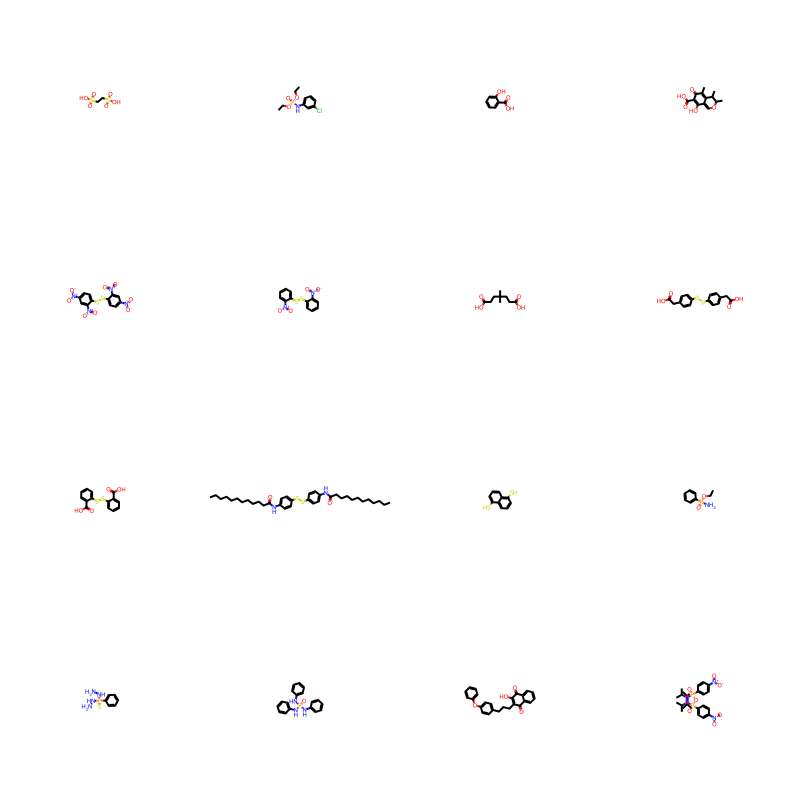

In [97]:
sample_smiles = data["smiles"][4:20].values
sample_labels= data['HIV_active'][4:20].values
sample_mols = [Chem.MolFromSmiles(smiles) for \
               smiles in sample_smiles]
grid = Draw.MolsToGridImage(sample_mols,
                            molsPerRow=4,
                            subImgSize=(200,200))
grid

In [98]:
def _get_node_features(mol):      
    all_node_feats = []

    for atom in mol.GetAtoms():
        node_feats = []
        # Feature 1: Atomic number        
        node_feats.append(atom.GetAtomicNum())
        # Feature 2: Atom degree
        node_feats.append(atom.GetDegree())
        # Feature 3: Formal charge
        node_feats.append(atom.GetFormalCharge())
        # Feature 4: Hybridization
        node_feats.append(atom.GetHybridization())
        # Feature 5: Aromaticity
        node_feats.append(atom.GetIsAromatic())
         # Feature 6: Total Num Hs
        node_feats.append(atom.GetTotalNumHs())
        # Feature 7: Radical Electrons
        node_feats.append(atom.GetNumRadicalElectrons())
        # Feature 8: In Ring
        node_feats.append(atom.IsInRing())
        # Feature 9: Chirality
        node_feats.append(atom.GetChiralTag())

        # Append node features to matrix
        all_node_feats.append(node_feats)

    all_node_feats = np.asarray(all_node_feats)
    return torch.tensor(all_node_feats, dtype=torch.float)

def _get_edge_features(mol):

    all_edge_feats = []

    for bond in mol.GetBonds():
        edge_feats = []
        # Feature 1: Bond type (as double)
        edge_feats.append(bond.GetBondTypeAsDouble())
        # Feature 2: Rings
        edge_feats.append(bond.IsInRing())
        # Append node features to matrix (twice, per direction)
        all_edge_feats += [edge_feats, edge_feats]

    all_edge_feats = np.asarray(all_edge_feats)
    return torch.tensor(all_edge_feats, dtype=torch.float)

def _get_adjacency_info(mol):
    edge_indices = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices += [[i, j], [j, i]]

    edge_indices = torch.tensor(edge_indices)
    edge_indices = edge_indices.t().to(torch.long).view(2, -1)
    return edge_indices

def _get_labels(label):
    label = np.asarray([label])
    return torch.tensor(label, dtype=torch.int64)


In [99]:
for smiles in sample_smiles:
    mol_obj = Chem.MolFromSmiles(smiles)
    node_feats = _get_node_features(mol_obj)
    edge_feats = _get_edge_features(mol_obj)
    edge_index = _get_adjacency_info(mol_obj)
    print(node_feats.shape,edge_feats.shape,edge_index.shape,smiles)
print(sample_labels)    
    

torch.Size([10, 9]) torch.Size([18, 2]) torch.Size([2, 18]) O=S(=O)(O)CCS(=O)(=O)O
torch.Size([16, 9]) torch.Size([32, 2]) torch.Size([2, 32]) CCOP(=O)(Nc1cccc(Cl)c1)OCC
torch.Size([10, 9]) torch.Size([20, 2]) torch.Size([2, 20]) O=C(O)c1ccccc1O
torch.Size([18, 9]) torch.Size([38, 2]) torch.Size([2, 38]) CC1=C2C(=COC(C)C2C)C(O)=C(C(=O)O)C1=O
torch.Size([26, 9]) torch.Size([54, 2]) torch.Size([2, 54]) O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+](=O)[O-])c([N+](=O)[O-])c1
torch.Size([20, 9]) torch.Size([42, 2]) torch.Size([2, 42]) O=[N+]([O-])c1ccccc1SSc1ccccc1[N+](=O)[O-]
torch.Size([13, 9]) torch.Size([24, 2]) torch.Size([2, 24]) CC(C)(CCC(=O)O)CCC(=O)O
torch.Size([22, 9]) torch.Size([46, 2]) torch.Size([2, 46]) O=C(O)Cc1ccc(SSc2ccc(CC(=O)O)cc2)cc1
torch.Size([20, 9]) torch.Size([42, 2]) torch.Size([2, 42]) O=C(O)c1ccccc1SSc1ccccc1C(=O)O
torch.Size([42, 9]) torch.Size([86, 2]) torch.Size([2, 86]) CCCCCCCCCCCC(=O)Nc1ccc(SSc2ccc(NC(=O)CCCCCCCCCCC)cc2)cc1
torch.Size([12, 9]) torch.Size(

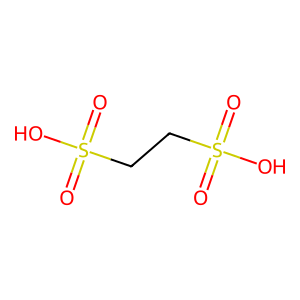

In [100]:
sample_mol_obj_0=Chem.MolFromSmiles(sample_smiles[0])
Draw.MolToImage(sample_mol_obj_0)

In [101]:
import deepchem as dc

In [102]:
sample_smiles

array(['O=S(=O)(O)CCS(=O)(=O)O', 'CCOP(=O)(Nc1cccc(Cl)c1)OCC',
       'O=C(O)c1ccccc1O', 'CC1=C2C(=COC(C)C2C)C(O)=C(C(=O)O)C1=O',
       'O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+](=O)[O-])c([N+](=O)[O-])c1',
       'O=[N+]([O-])c1ccccc1SSc1ccccc1[N+](=O)[O-]',
       'CC(C)(CCC(=O)O)CCC(=O)O', 'O=C(O)Cc1ccc(SSc2ccc(CC(=O)O)cc2)cc1',
       'O=C(O)c1ccccc1SSc1ccccc1C(=O)O',
       'CCCCCCCCCCCC(=O)Nc1ccc(SSc2ccc(NC(=O)CCCCCCCCCCC)cc2)cc1',
       'Sc1cccc2c(S)cccc12', 'CCOP(N)(=O)c1ccccc1', 'NNP(=S)(NN)c1ccccc1',
       'O=P(Nc1ccccc1)(Nc1ccccc1)Nc1ccccc1',
       'O=C1C(O)=C(CCCc2ccc(Oc3ccccc3)cc2)C(=O)c2ccccc21',
       'CC(C)N(C(C)C)P(=O)(OP(=O)(c1ccc([N+](=O)[O-])cc1)N(C(C)C)C(C)C)c1ccc([N+](=O)[O-])cc1'],
      dtype=object)

In [103]:
featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)
out=featurizer.featurize(sample_smiles)

In [104]:
out

array([<deepchem.feat.graph_data.GraphData object at 0x000001D39B4078D0>,
      dtype=object)

In [105]:
out[0].node_features

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0

In [112]:
out[0].edge_features

array([[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [106]:
type(out),type(out[0])

(numpy.ndarray, deepchem.feat.graph_data.GraphData)

In [107]:
out.shape,out.ndim

((16,), 1)

In [108]:
out[0].num_node_features,out[0].num_edge_features


(30, 11)

In [109]:
out[0].node_features.shape,out[0].edge_features.shape

((10, 30), (18, 11))

In [110]:
out[0].edge_index.shape,out[0].edge_index

((2, 18),
 array([[0, 2, 2, 7, 2, 8, 2, 3, 3, 9, 9, 4, 4, 5, 4, 1, 4, 6],
        [2, 0, 7, 2, 8, 2, 3, 2, 9, 3, 4, 9, 5, 4, 1, 4, 6, 4]]))

In [111]:
g0=out[0].to_pyg_graph()
g0

Data(x=[10, 30], edge_index=[2, 18], edge_attr=[18, 11])